In [36]:
from ROOT import RDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm

from fftprep.fftprep import make_img, fft_filter, fft_filter_pairwise, reconstruct_img, complete_data_pw, load_from_sparse, fftpredictor, params_pairwise

from sklearn.neural_network import MLPRegressor

from scipy.signal import detrend

import pickle

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.optimize import curve_fit

In [126]:
data = RDataFrame("t;1", "FullSim_E5GeV.root").AsNumpy()
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_full, obs_full = X[subset], obs[subset]
del X
del obs

In [61]:
data = RDataFrame("t;1", "FastSim_E5GeV.root").AsNumpy()
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_fast, obs_fast = X[subset], obs[subset]
del X
del obs

In [12]:
full_data_binned_pw = fft_filter_pairwise(X_full, obs_full, params_pairwise, no_filter = True)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.24it/s]


[2/2] creating image...
[1/2] performing fast Fourier transform along 2 axes...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


[2/2] creating image...
[1/2] performing fast Fourier transform along 2 axes...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.89it/s]


[2/2] creating image...
[1/2] performing fast Fourier transform along 2 axes...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.59it/s]


[2/2] creating image...
[1/2] performing fast Fourier transform along 2 axes...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.02it/s]


[2/2] creating image...
[1/2] performing fast Fourier transform along 2 axes...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.03it/s]


[2/2] creating image...
[1/2] performing fast Fourier transform along 2 axes...


In [15]:
for key in full_data_binned_pw.keys():
    full_data_binned_pw[key] = abs(np.fft.ifftn(full_data_binned_pw[key]))

In [133]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.05),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

model = fftpredictor(full_data_binned_pw, params)

fft_filt_data_pw = load_from_sparse(return_full=True, n_sigma = 1)

params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.6),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

model = fftpredictor(fft_filt_data_pw, params)

In [441]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.6),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

sigmas = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for n_sigma in sigmas:
    fft_filt_data_pw = load_from_sparse(return_full=True, n_sigma = n_sigma)
    model = fftpredictor(fft_filt_data_pw, params)
    preds = []
    for row in tqdm(X_full):
        preds.append(model.predict((row[1], row[2], row[4], row[5]), mode="reg"))
    print(np.sqrt(np.mean((preds-obs_full)**2)))

100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:37<00:00, 73170.18it/s]


52.88390833652299


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:39<00:00, 72993.26it/s]


52.889362682831944


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:30<00:00, 73884.77it/s]


52.89389108693766


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:43<00:00, 72505.61it/s]


52.897966303845635


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:37<00:00, 73155.10it/s]


52.90218385259446


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:36<00:00, 73310.68it/s]


52.90716665743619


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:40<00:00, 72894.61it/s]


52.91258672458738


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:34<00:00, 73492.41it/s]


52.91760087897669


100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:35<00:00, 73341.81it/s]


52.923134396156875


In [144]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
full_data_pw_avg = make_img(X_full, np.array(preds), params)
full_data = make_img(X_full, obs_full, params)

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 440.67it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 388.57it/s]


[2/2] creating image...


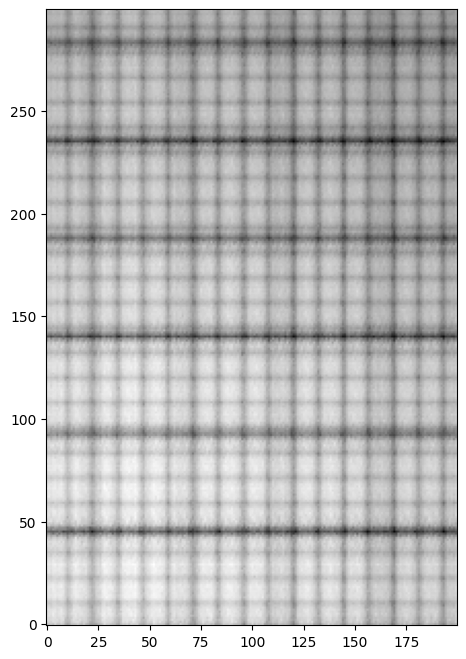

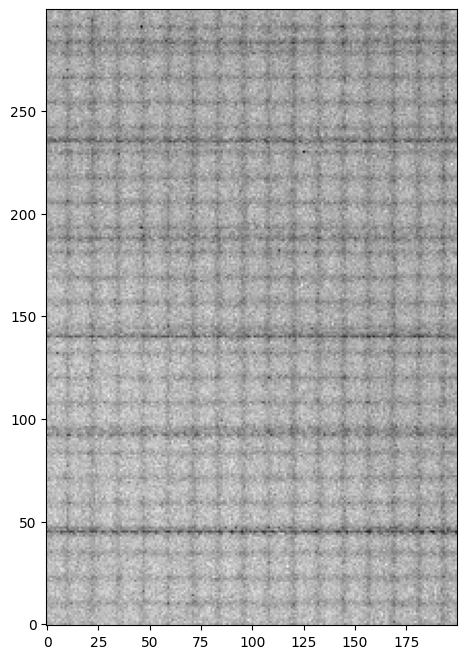

In [145]:
plt.figure(figsize=(12,8))
plt.imshow(full_data_pw_avg, cmap='gray', origin="lower")
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(full_data, cmap='gray', origin="lower")
plt.show()

In [437]:
fft_filt_data_pw = load_from_sparse(return_full=True, n_sigma = 1)

params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.05),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

model = fftpredictor(fft_filt_data_pw, params)

In [438]:
preds = []
for row in tqdm(X_full):
    preds.append(model.predict((row[1], row[2], row[4], row[5]), mode="reg"))

100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [11:43<00:00, 72517.29it/s]


In [439]:
preds = np.array(preds)

In [27]:
featurized_data = np.concatenate(
    (
        preds, 
        X_full.transpose()[1].reshape(-1,1), 
        X_full.transpose()[2].reshape(-1,1), 
        X_full.transpose()[4].reshape(-1,1), 
        X_full.transpose()[5].reshape(-1,1)
    ),
    axis=1
)

In [375]:
preds-obs

NameError: name 'obs' is not defined

In [37]:
scaler = StandardScaler()
scaler.fit(featurized_data)

StandardScaler()

In [40]:
reg = LinearRegression().fit(featurized_data, obs_full)

In [148]:
reg.coef_

array([ 4.62667322e-02,  4.05903633e-01,  7.37053102e-01,  7.11026542e-01,
        7.91679688e-01, -1.10608644e-01,  6.14513947e-04,  1.31066293e-03,
        3.10288707e-01, -6.53760741e-02])

In [423]:
np.sqrt(np.mean((fft_regr_preds- full_data)**2))

1.8648698109200652

In [422]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.01
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.01
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": 10
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": 1
    }
}
fft_regr_preds = make_img(X_full, preds, params)
fast_preds = make_img(X_fast, obs_fast, params)
full_data = make_img(X_full, obs_full, params)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.64it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


[2/2] creating image...


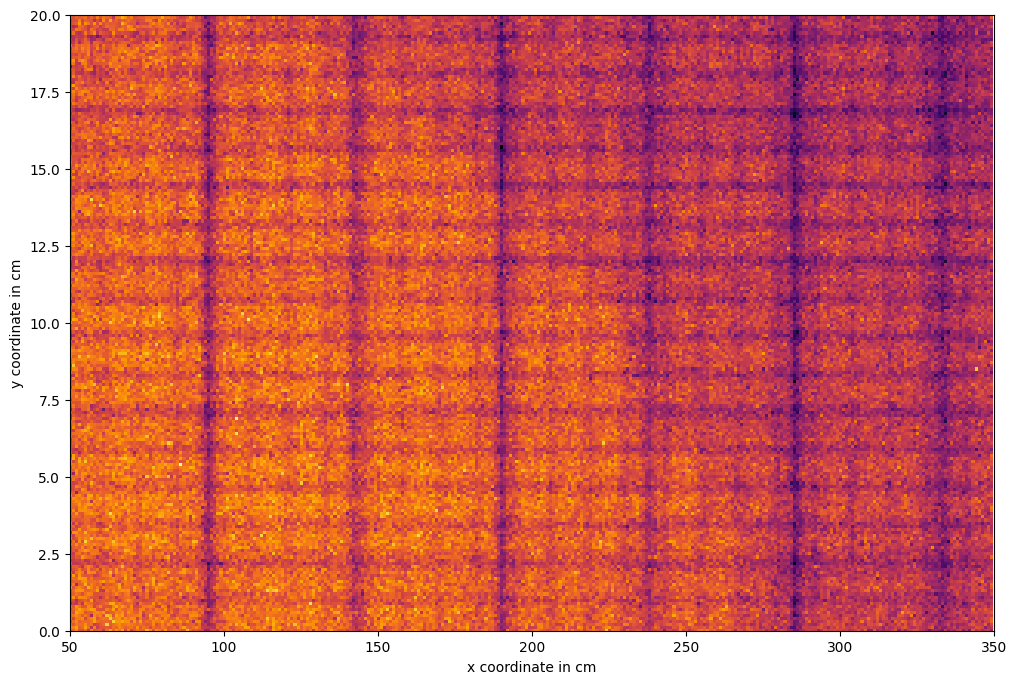

In [374]:
interpolation_weights = np.random.beta(
    (abs(fft_regr_preds-np.max(fft_regr_preds)*2)/(np.std(fft_regr_preds)))**2,
    0.7*(abs(fft_regr_preds-np.max(fft_regr_preds)*2)/(np.std(fft_regr_preds)))**2, 
    size=(300,200)
)
corrected_preds = (fft_regr_preds*interpolation_weights + fast_preds*(1-interpolation_weights))
plt.figure(figsize=(12,8))
plt.imshow(corrected_preds.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [item/10 for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 200)
plt.xlabel("x coordinate in cm")
plt.ylabel("y coordinate in cm")
plt.savefig('XvY_fast_with_corrections.pdf')

In [ ]:
np.mean()

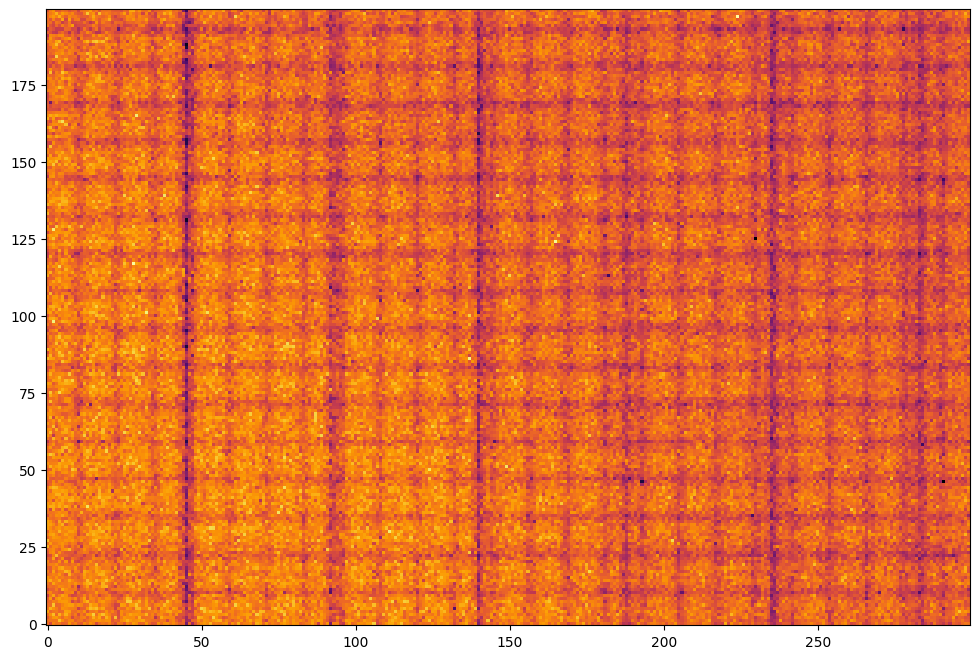

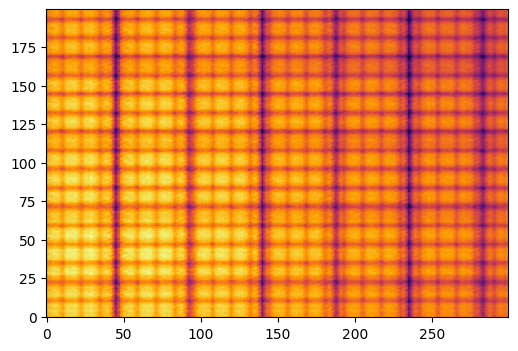

In [313]:
plt.figure(figsize=(12,8))
plt.imshow(full_data.transpose(), cmap='inferno', origin="lower")
plt.show()
plt.figure(figsize=(6,4))
plt.imshow(fft_regr_preds.transpose(), cmap='inferno', origin="lower")
plt.show()

In [409]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_preds = make_img(X_full, preds, params)
x_profile_obs = make_img(X_full, obs_full, params)
x_profile_fast= make_img(X_fast, obs_fast, params)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.52it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 54.89it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 53.81it/s]


[2/2] creating image...


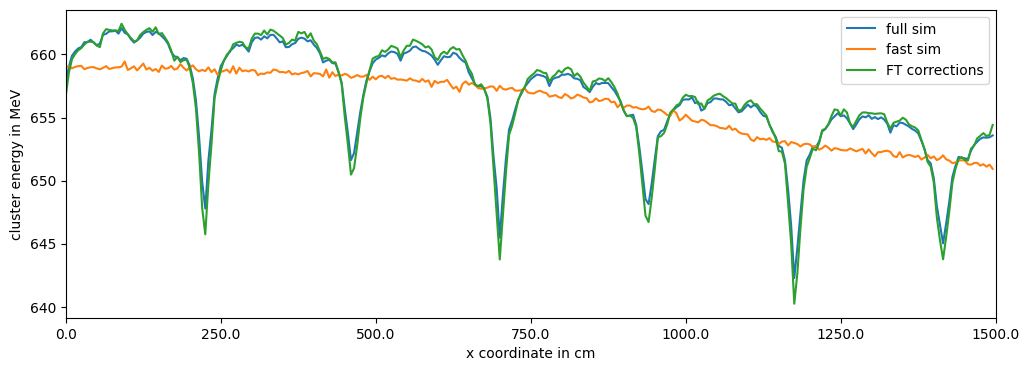

In [412]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_preds = make_img(X_full, preds, params)
x_profile_obs = make_img(X_full, obs_full, params)
x_profile_fast= make_img(X_fast, obs_fast, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.plot(x_profile_fast)
plt.plot(x_profile_preds)
plt.xlabel("x coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])
locs, labels = plt.xticks()
labels = [float(item)*5 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
plt.savefig('fftprep/plots/X_axis_comparison_full_vs_fast_vs_ft.pdf')

In [260]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_preds = make_img(X_full, preds_updated, params)
x_profile_obs = make_img(X_full, obs_full, params)
x_profile_fast= make_img(X_fast, obs_fast, params)

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 340.51it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 821.00it/s]


[2/2] creating image...
[1/2] binning data...


100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1110.19it/s]


[2/2] creating image...


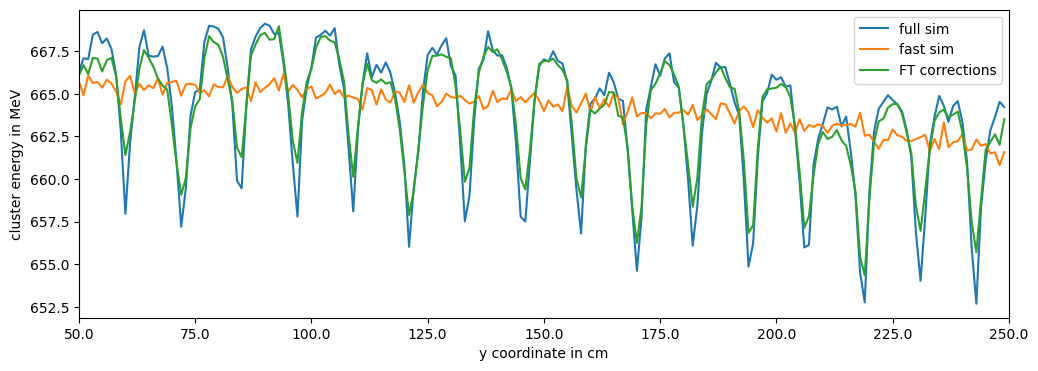

In [262]:
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.plot(x_profile_fast)
plt.plot(x_profile_preds)
plt.xlabel("y coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])
locs, labels = plt.xticks()
labels = [float(item)+50 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 200)
plt.savefig('Y_axis_comparison_theta<0.05_full_vs_fast_vs_ft.pdf')

In [415]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": 100
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_preds = make_img(X_full, preds_updated, params)
x_profile_obs = make_img(X_full, obs_full, params)
x_profile_fast= make_img(X_fast, obs_fast, params)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.40it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 61.55it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 55.27it/s]


[2/2] creating image...


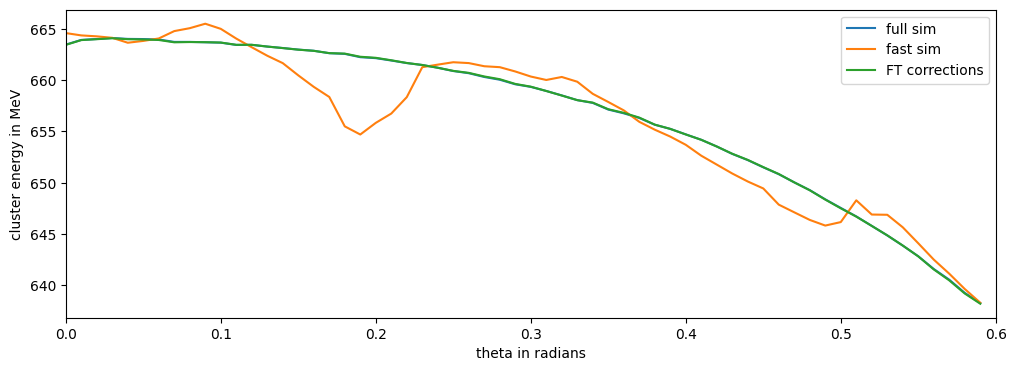

In [416]:
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.plot(x_profile_fast)
plt.plot(x_profile_preds)
plt.xlabel("theta in radians")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])
locs, labels = plt.xticks()
labels = [float(item)/10 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 63)
plt.savefig('fftprep/plots/theta_axis_comparison_full_vs_fast_vs_ft.pdf')

In [252]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": 10
    }
}
binned_preds = make_img(X_full, preds, params)
binned_obs = make_img(X_full, obs_full, params)
binned_fast= make_img(X_fast, obs_fast, params)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.62it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.55it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.54it/s]


[2/2] creating image...


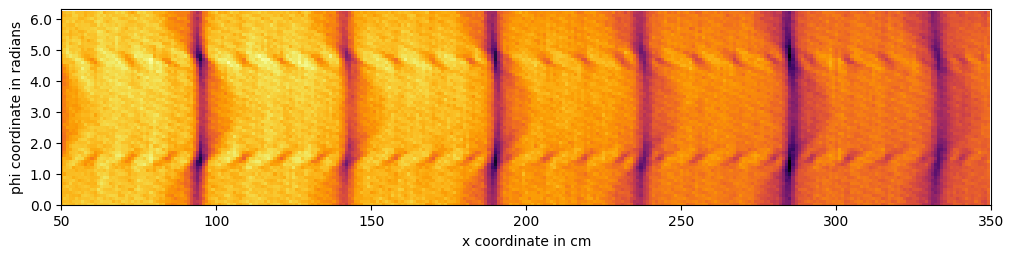

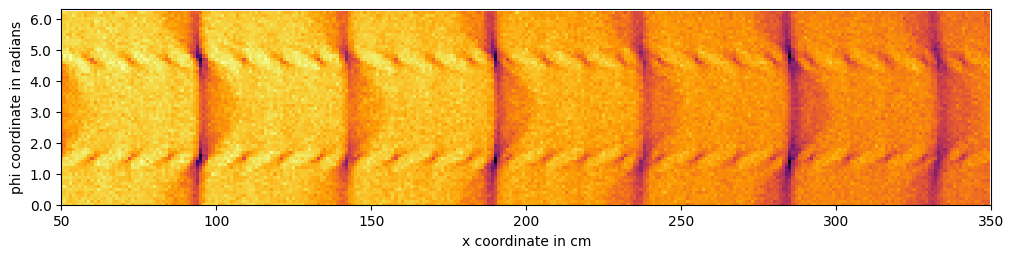

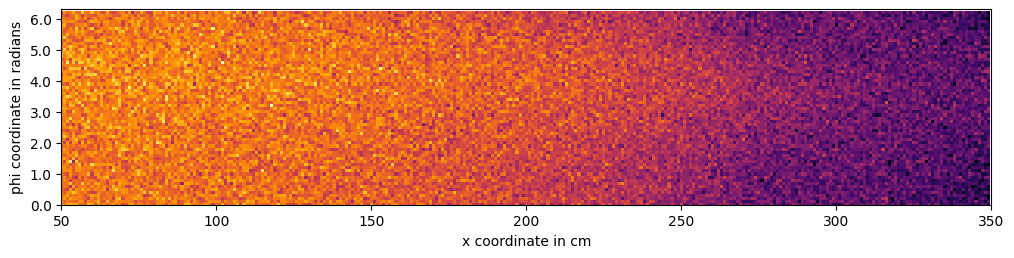

In [255]:
plt.figure(figsize=(12,8))
plt.imshow(binned_preds.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [item/10 for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 63)
plt.xlabel("x coordinate in cm")
plt.ylabel("phi coordinate in radians")
plt.savefig('Xvphi_ft.pdf')

plt.figure(figsize=(12,8))
plt.imshow(binned_obs.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [item/10 for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 63)
plt.xlabel("x coordinate in cm")
plt.ylabel("phi coordinate in radians")
plt.savefig('Xvphi_full.pdf')

plt.figure(figsize=(12,8))
plt.imshow(binned_fast.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [item/10 for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 63)
plt.xlabel("x coordinate in cm")
plt.ylabel("phi coordinate in radians")
plt.savefig('Xvphi_fast.pdf')

In [231]:
preds

array([656.19401799, 663.09058809, 643.95352288, ..., 662.17099875,
       651.36373724, 662.75669595])

In [155]:
class fftpredictor():
    def __init__(self, data=None, params=None, n_sigma=1):
        if data is None:
            self.data = load_from_sparse(return_full=True, n_sigma=n_sigma, background_pw=None)
        else:
            self.data = data
        self.params = params
        if params is None:
            self.params = {
                "X": {
                    "range": (500, 3500),
                    "reso": 0.1
                },
                "Y": {
                    "range": (500, 2500),
                    "reso": 0.1
                }
                ,
                "theta": {
                    "range": (0, 0.05),
                    "reso": 100
                },
                "phi": {
                    "range": (0, 2 * np.pi),
                    "reso": 10
                }
            }
        else:
            self.params = params
        self.coef_ = np.array([4.62667322e-02, 4.05903633e-01, 7.37053102e-01, 7.11026542e-01,
                               7.91679688e-01, -1.10608644e-01, 6.14513947e-04, 1.31066293e-03,
                               3.10288707e-01, -6.53760741e-02])
        self.intercept_ = -1041.5137464080813

    def predict(self, vec, mode="reg"):

        if mode == "avg":
            predictions_pw = 0
            coords = list(combinations(vec, 2))
            for i, key in enumerate(self.data.keys()):
                var1 = key.split("_")[0]
                var2 = key.split("_")[2]
                coords_scales = (
                    int((coords[i][0] - self.params[var1]["range"][0]) * self.params[var1]["reso"]),
                    int((coords[i][1] - self.params[var2]["range"][0]) * self.params[var2]["reso"])
                )
                predictions_pw += self.data[key][coords_scales]
            return predictions_pw / 6

        if mode == "all":
            predictions_pw = []
            coords = list(combinations(vec, 2))
            for i, key in enumerate(self.data.keys()):
                var1 = key.split("_")[0]
                var2 = key.split("_")[2]
                coords_scales = (
                    int((coords[i][0] - self.params[var1]["range"][0]) * self.params[var1]["reso"]),
                    int((coords[i][1] - self.params[var2]["range"][0]) * self.params[var2]["reso"])
                )
                predictions_pw.append(self.data[key][coords_scales])
            return predictions_pw

        if mode == "reg":
            predictions_pw = []
            coords = list(combinations(vec, 2))
            for i, key in enumerate(self.data.keys()):
                var1 = key.split("_")[0]
                var2 = key.split("_")[2]
                coords_scales = (
                    int((coords[i][0] - self.params[var1]["range"][0]) * self.params[var1]["reso"]),
                    int((coords[i][1] - self.params[var2]["range"][0]) * self.params[var2]["reso"])
                )
                predictions_pw.append(self.data[key][coords_scales])
            reg_inputs = np.array(predictions_pw + list(vec))
            return sum(reg_inputs * self.coef_) + self.intercept_

    def fit_linear(self, inputs, outputs):
        print("[1/2] Getting predictions for each coordinate pair from FFT data...")
        preds = []
        for row in tqdm(inputs):
            preds.append(self.predict(row, mode="all"))
        print("[2/2] computing linear regression coefficients...")
        preds = np.array(preds)
        inputs_featurized = np.concatenate((preds, inputs), axis=1)
        reg = LinearRegression().fit(inputs_featurized, outputs)
        self.coef_ = reg.coef_
        self.intercept_ = reg.intercept_

In [156]:
model = fftpredictor()

In [166]:
model.predict([3000.1235, 1259.315, 0.18244433, 0.1])

664.2489151932168

In [296]:
abs(fft_regr_preds-np.max(fft_regr_preds))

array([[ 9.77583678,  9.18023002,  8.58690965, ..., 14.41806344,
        13.65783482, 12.17787171],
       [ 7.74292168,  6.59014526,  7.54486271, ..., 11.38965801,
        11.4762958 ,  8.37537762],
       [ 5.84253257,  6.43220524,  6.0139254 , ..., 10.64249156,
        10.67868787,  8.97640265],
       ...,
       [13.80230967, 13.75931045, 13.51101215, ..., 17.99802971,
        17.21161494, 16.10687786],
       [13.28983206, 13.65017647, 13.71886178, ..., 17.39799432,
        18.04996125, 15.69560916],
       [13.22695983, 12.02291041, 12.15215097, ..., 15.63633202,
        16.26957328, 15.23913493]])

In [440]:
np.sqrt(np.mean((preds-obs_full)**2))

ndarray(52.88390834)

In [430]:
1.865/(obs_full.max() - obs_full.min())

ndarray(0.00184858)

In [426]:
np.std(obs_full)

ndarray(53.659035, dtype=float32)

In [431]:
class fftpredictor():
    def __init__(self, data=None, params=None, n_sigma=1):
        if data is None:
            self.data = load_from_sparse(return_full=True, n_sigma=n_sigma, background_pw=None)
        else:
            self.data = data
        self.params = params
        if params is None:
            self.params = {
                "X": {
                    "range": (500, 3500),
                    "reso": 0.1
                },
                "Y": {
                    "range": (500, 2500),
                    "reso": 0.1
                }
                ,
                "theta": {
                    "range": (0, 0.05),
                    "reso": 100
                },
                "phi": {
                    "range": (0, 2 * np.pi),
                    "reso": 10
                }
            }
        else:
            self.params = params
        self.coef_ = np.array([4.62667322e-02, 4.05903633e-01, 7.37053102e-01, 7.11026542e-01,
                               7.91679688e-01, -1.10608644e-01, 6.14513947e-04, 1.31066293e-03,
                               3.10288707e-01, -6.53760741e-02])
        self.intercept_ = -1041.5137464080813

    def predict(self, vec, mode="reg"):

        if mode == "avg":
            predictions_pw = 0
            coords = list(combinations(vec, 2))
            for i, key in enumerate(self.data.keys()):
                var1 = key.split("_")[0]
                var2 = key.split("_")[2]
                coords_scales = (
                    int((coords[i][0] - self.params[var1]["range"][0]) * self.params[var1]["reso"]),
                    int((coords[i][1] - self.params[var2]["range"][0]) * self.params[var2]["reso"])
                )
                predictions_pw += self.data[key][coords_scales]
            return predictions_pw / 6

        if mode == "all":
            predictions_pw = []
            coords = list(combinations(vec, 2))
            for i, key in enumerate(self.data.keys()):
                var1 = key.split("_")[0]
                var2 = key.split("_")[2]
                coords_scales = (
                    int((coords[i][0] - self.params[var1]["range"][0]) * self.params[var1]["reso"]),
                    int((coords[i][1] - self.params[var2]["range"][0]) * self.params[var2]["reso"])
                )
                predictions_pw.append(self.data[key][coords_scales])
            return predictions_pw

        if mode == "reg":
            predictions_pw = []
            coords = list(combinations(vec, 2))
            for i, key in enumerate(self.data.keys()):
                var1 = key.split("_")[0]
                var2 = key.split("_")[2]
                coords_scales = (
                    int((coords[i][0] - self.params[var1]["range"][0]) * self.params[var1]["reso"]),
                    int((coords[i][1] - self.params[var2]["range"][0]) * self.params[var2]["reso"])
                )
                predictions_pw.append(self.data[key][coords_scales])
            reg_inputs = np.array(predictions_pw + list(vec))
            return sum(reg_inputs * self.coef_) + self.intercept_

In [442]:
performace_data = [52.88390833652299, 52.889362682831944, 52.89389108693766, 52.897966303845635, 52.90218385259446, 52.90716665743619, 52.91258672458738, 52.91760087897669, 52.923134396156875]

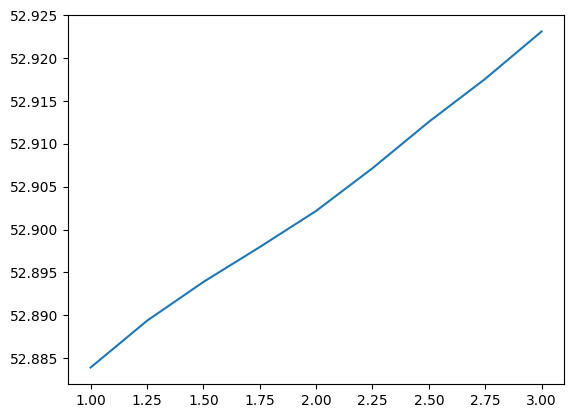

In [443]:
plt.plot(sigmas, performace_data)